In [1]:
using NBInclude

@nbinclude("functions.ipynb")

All function imported


load_model_identity (generic function with 1 method)

In [5]:
function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST.testdata(Float32)
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

function load_model_sep(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar W1 W2 W3 Q
    println("Done")
    return encoder_μ, encoder_logvar, W1, W2, W3, Q
end

function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder decoder_last
    println("Done")
    return encoder_μ, encoder_logvar, decoder, decoder_last
    
end

function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder 
    println("Done")
    return encoder_μ, encoder_logvar, decoder
    
end


# setup
# experiments with MNIST dataset
x_dim = 784
k = 20

tolerance = 1e-7; max_iter = 6000; out_toggle = 0
trials = 5
opt = Flux.Optimise.ADAM(.1);

encoder_μ_inco, encoder_logvar_inco,  decoder = load_model("trained_GNN/MNIST", 20)

B = randn(784, 500)/sqrt(784)
F = dct(diagm(ones(x_dim)),2);

A = Flux.params(decoder)[3]
β_list, α_list = get_β_α(F, A, B, 20);


Loading model...Done


In [6]:


m_list = 20:10:200
β_list, α_list = get_β_α(F, Q_co, B, 20);
recovery_error_matrix = zeros(trials, 1 + length(β_list) )
recon_error_matrix = zeros(trials, 1 + length(β_list) );

W1_rand = randn(500, 20)/sqrt(500)
W2_rand = randn(500,500)/sqrt(500)



500×500 Matrix{Float64}:
 -0.0204577    0.0165869    0.0781594   …  -0.0041146    0.0712603
  0.0316505   -0.0344991   -0.00358231      0.033014     0.100178
  0.0273701   -0.0769136    0.0737511      -0.065623    -0.0346784
  0.0460947   -0.0119835   -0.0264268       0.0394477   -0.0085065
 -0.0826533   -0.0256781    0.0931853       0.00308107   0.0773482
  0.0156022    0.0641675    0.00894437  …  -0.0477806    0.00784939
 -0.00516991  -0.0718876   -0.0127398       0.0544218    0.0939998
 -0.0107381    0.0406702    0.0601728      -0.0196137    0.0862042
 -0.0308578   -0.00582695   0.0192399      -0.0125836    0.011992
 -0.0450072   -0.0128458   -0.0281832       0.0325575   -0.0112916
  ⋮                                     ⋱               
 -0.0541949   -0.0632659    0.00801476      0.0238296   -0.000574904
 -0.00116681  -0.121344     0.0223968       0.0534398   -0.0568158
 -0.071555    -0.0315327    0.0180072       0.00955691  -0.0015641
  0.048732    -0.00449226  -0.0545786      -0.

In [ ]:
z = randn(k); norm(z)
β_list

In [16]:
trials = 15
phase_matrix_recovery = zeros(trials, length(m_list), length(β_list))
phase_matrix_recon = zeros(trials, length(m_list), length(β_list))


Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    recovery_error_matrix = zeros(trials)
    recon_error_matrix = zeros(trials)
    for β in β_list
        recovery_error_list = []
        recon_error_list = []
        G = Chain(
            Dense(20, 500, relu, bias = false; init =(out,in) ->  Flux.params(decoder)[1]),
            Dense(500, 500, relu, bias = false; init =(out,in) -> Flux.params(decoder)[2]),
            Dense(500, 784, identity, bias = false; init =(out,in) -> β * A + (1-β)*B),
        )      #setup the generative network 

        for trials in 1:trials
            F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
            F_sub = F_sub * sqrt(x_dim)/sqrt(m) #normalization          
            y = F_sub * G(z) # measurement vector using subsampled DCT matrix

            z_est = randn(k) #initialization for algorithm
            z_est = estimated_code(opt, G, y, F_sub, z_est; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem

            push!(recovery_error_list, relative_error(z, z_est))    
            push!(recon_error_list, relative_error(G(z), G(z_est)))
        end

        recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
        recon_error_matrix = hcat(recon_error_matrix, recon_error_list)
    end
    phase_matrix_recovery[:, i, :] = recovery_error_matrix[:, 2:end]
    phase_matrix_recon[:, i, :] = recon_error_matrix[:, 2:end]
    println("Done with m = $m")
println("")
end



Done with m = 130

Done with m = 190

Done with m = 110

Done with m = 150

Done with m = 170

Done with m = 80

Done with m = 50

Done with m = 140

Done with m = 120

Done with m = 160

Done with m = 200

Done with m = 180

Done with m = 90

Done with m = 60

Done with m = 100

Done with m = 70

Done with m = 20



Done with m = 30



Done with m = 40



In [23]:
save("saved_data/Phase_plot_MNIST_paper_v4.jld", "phase_matrix_recovery", phase_matrix_recovery, "phase_matrix_recon", phase_matrix_recon, "α_list", α_list, "m_list", m_list, "trials", trials)





In [24]:
phase_matrix_recon = phase_matrix_recon_temp
phase_matrix_recovery = phase_matrix_recovery_temp

20×19×20 Array{Float64, 3}:
[:, :, 1] =
  3.05491    2.44848e-6   1.90162e-6  …  8.86854e-7  8.65645e-7  1.10035e-6
  5.51135    2.98406e-6   2.09272e-6     9.6646e-7   9.82466e-7  9.74457e-7
  3.23901    0.186213     1.70888e-6     1.04834e-6  1.44411e-6  1.27354e-6
  3.24588    2.23389e-6   2.27492e-6     6.01908e-7  1.4123e-6   6.50503e-7
  5.0538     2.88553e-6   1.41102e-6     1.09704e-6  9.98611e-7  1.15691e-6
  2.81062    1.78137e-6   1.86868e-6  …  8.07171e-7  1.13601e-6  9.11612e-7
  4.5939     0.0113192    1.56251e-6     1.45594e-6  9.28237e-7  9.87513e-7
  0.673393   2.33065e-6   2.83823e-6     9.64182e-7  4.84685e-7  9.98737e-7
  1.85079   12.667       11.4748         1.14506e-6  9.38517e-7  9.9679e-7
  1.25265    2.39968e-6   1.05241e-6     5.1277e-7   7.587e-7    7.25782e-7
  5.01416    6.46345      2.04357e-6  …  9.18763e-7  6.71354e-7  1.17517e-6
  6.83509    2.89331e-6   2.35397e-6     1.20901e-6  6.29511e-7  5.77439e-7
  7.11029    0.0855378    2.07463e-6     1.65138e

In [25]:
M = zeros(size(phase_matrix_recovery[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-2)
end
trials = 20

20

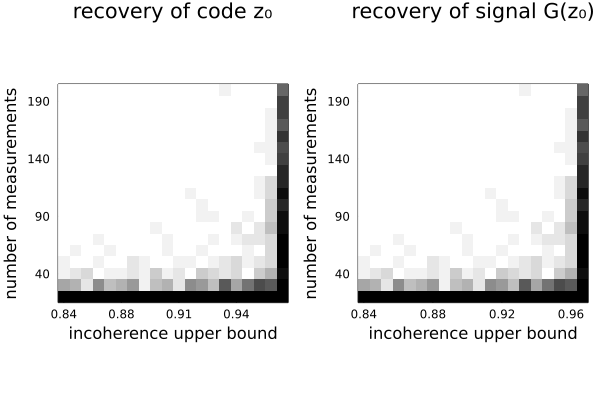

In [27]:
M = zeros(size(phase_matrix_recovery[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-5)
end
p1 = plot(colorview(Gray, reverse(M/trials, dims = 1)), bg =:black, title = "recovery of code z₀", framestyle = :box)
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])


M = zeros(size(phase_matrix_recon[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-5)
end

p2 = plot(colorview(Gray, reverse(M/trials, dims = 1)), bg =:black, title = "recovery of signal G(z₀)",framestyle = :box)
xticks = 1:6:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:6:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])
# plot!(1:length(α_list), ff.(m_pred), label =:false, linewidth = 2 )

plot(p1, p2, layout = 2, xlabel = "incoherence upper bound", ylabel = "number of measurements")
# savefig("figures/Phase_MNIST_paper.pdf")



In [95]:


M = sum(phase_matrix_recovery,dims =1)[1,:,:]/20; M[M .>1] .= 1
p1 = plot(colorview(Gray, reverse(M,dims=1)), framestyle = :box, bg =:black, title = "recovery of code z₀")
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])

M = sum(phase_matrix_recon,dims =1)[1,:,:]/20; M[M .>1] .= 1
p2 = plot(colorview(Gray, reverse(M,dims=1)), framestyle = :box, bg =:black, title = "recovery of signal G(z₀)")
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])

plot(p1, p2, layout = 2,  bg =:white)
savefig("figures/Phase_plot_Full_MNIST_error.pdf")

